# Generación de Spark Dataframe
Con este script se copian los datos input del modelo al bucket del storage.



In [1]:
#from __future__ import absolute_import
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--name "rec_cuenta" --master yarn --conf spark.executor.memory=3G --conf spark.executor.cores=1 --conf spark.executor.instances=32 pyspark-shell' 


#!{sys.executable} -m pip install --upgrade pip
#!{sys.executable} -m pip install py4j==0.10.7 --force-reinstall
#!{sys.executable} -m pip install numpy==1.15.4
#!{sys.executable} -m pip install pandas==0.24.1
#!{sys.executable} -m pip install pandas-gbq==0.9.0
#!{sys.executable} -m pip install google-cloud-bigquery==1.9.0
#!{sys.executable} -m pip install google-cloud-storage==1.14.0
#!{sys.executable} -m pip freeze
#!{sys.executable} -m pip install seaborn
#!{sys.executable} -m pip install tensorflow
#!{sys.executable} -m pip install google
#!{sys.executable} -m pip install datalab
#!{sys.executable} -m pip install pyspark


In [2]:
#from __future__ import absolute_import
#import sys
#!{sys.executable} -m pip install tensorboard


In [3]:

import numpy as np
import tensorflow as tf
import shutil
import io
import pandas as pd
from pyspark.sql.functions import explode, col, log, collect_list, collect_set, udf, array, size, to_json, struct, when, lit
from pyspark.sql.types import ArrayType, FloatType,StringType, IntegerType, StructType, StructField,DoubleType
from pyspark.ml.linalg import SparseVector

import pyspark
from pyspark.context import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.session import SparkSession
from pyspark.sql import Row


In [4]:
### DESCOMENTAR LA SIGUIENTE LÍNEA PARA PASO A PRODUCCIÓN ###

#sc = SparkContext()
#spark = sparkSession(sc)
#sc
#sc.getConf().getAll()
sc.getConf().toDebugString()

'spark.app.id=application_1551903967241_0169\nspark.app.name=pyspark-shell\nspark.driver.appUIAddress=http://dprc-mkt-tensorflow-tony-jupyter-m.c.sistemas-bi.internal:4040\nspark.driver.extraJavaOptions=-Dflogger.backend_factory=com.google.cloud.hadoop.repackaged.gcs.com.google.common.flogger.backend.log4j.Log4jBackendFactory#getInstance\nspark.driver.host=dprc-mkt-tensorflow-tony-jupyter-m.c.sistemas-bi.internal\nspark.driver.maxResultSize=1920m\nspark.driver.memory=3840m\nspark.driver.port=34521\nspark.dynamicAllocation.enabled=true\nspark.dynamicAllocation.maxExecutors=10000\nspark.dynamicAllocation.minExecutors=1\nspark.eventLog.dir=hdfs://dprc-mkt-tensorflow-tony-jupyter-m/user/spark/eventlog\nspark.eventLog.enabled=true\nspark.executor.cores=1\nspark.executor.extraJavaOptions=-Dflogger.backend_factory=com.google.cloud.hadoop.repackaged.gcs.com.google.common.flogger.backend.log4j.Log4jBackendFactory#getInstance\nspark.executor.id=driver\nspark.executor.instances=32\nspark.executor

## Leyendo data desde la carpeta local

In [5]:
bucket = sc._jsc.hadoopConfiguration().get('fs.gs.system.bucket')
print(bucket)

#project = sc._jsc.hadoopConfiguration().get('fs.gs.project.id')
#print(project)
    
#todays_date = datetime.strftime(datetime.today(), "%Y_%m_%d_%H_%M_%S")
#input_directory = "gs://{}/tmp/spsa-{}".format(bucket, todays_date)
#input_directory = "gs://{}/datasets_prueba/".format(bucket)
#print(input_directory)


pry_spsa


## Creación de rutas para leer data, guardar diccionarios y guardar ouputs 

In [6]:
# reading from bucket
bucket = sc._jsc.hadoopConfiguration().get('fs.gs.system.bucket')
print(bucket)
todays_date = '2019_02_18_13_39_11' #'2019_02_15_19_01_20'
bucket_name = "datasets_prueba"
datafr_name = "local"
bucket_path = "gs://{}/{}/{}/{}".format(bucket, bucket_name, datafr_name, todays_date)
print(bucket_path)


pry_spsa
gs://pry_spsa/datasets_prueba/local/2019_02_18_13_39_11


In [7]:
# Ruta para guardar los diccionarios generados

bucket = sc._jsc.hadoopConfiguration().get('fs.gs.system.bucket')
bucket_name_subfolder = "research"
datafr_name = "codigo_cuenta_rec"
type_data = "diccionario_tf_idf"
bucket_path_diccionario = "gs://{}/{}/{}/{}/".format(bucket, bucket_name_subfolder, datafr_name, type_data)
print(bucket_path_diccionario)

gs://pry_spsa/research/codigo_cuenta_rec/diccionario_tf_idf/


In [8]:
# Ruta para guardar los datos que se usaran para validación cruzada con el rating continuo

#type_data = "output_tf_idf_continuo"
#bucket_path_output_tf_idf_continuo = "gs://{}/{}/{}/{}/".format(bucket, bucket_name_subfolder, datafr_name, type_data)
#print(bucket_path_output_tf_idf_continuo)

gs://pry_spsa/research/codigo_cuenta_rec/output_tf_idf_continuo/


In [9]:
# Ruta para guardar los datos que se usaran para validación cruzada con el rating binario

#type_data = "output_tf_idf_binario"
#bucket_path_output_tf_idf_binario = "gs://{}/{}/{}/{}/".format(bucket, bucket_name_subfolder, datafr_name, type_data)
#print(bucket_path_output_tf_idf_binario)

gs://pry_spsa/research/codigo_cuenta_rec/output_tf_idf_binario/


In [10]:
#Ruta para guardar los datos continuos

training_folder_name="training_continuo_TF_IDF"
testing_folder_name="testing_continuo_TF_IDF"
eval_folder_name="eval_continuo_TF_IDF"

bucket_path_tf_idf_training_continuo = "gs://{}/{}/{}/{}/".format(bucket, bucket_name_subfolder, datafr_name,training_folder_name)
bucket_path_tf_idf_testing_continuo = "gs://{}/{}/{}/{}/".format(bucket, bucket_name_subfolder, datafr_name,testing_folder_name)
bucket_path_tf_idf_eval_continuo = "gs://{}/{}/{}/{}/".format(bucket, bucket_name_subfolder, datafr_name,eval_folder_name)

print(bucket_path_tf_idf_training_continuo)
print(bucket_path_tf_idf_testing_continuo)
print(bucket_path_tf_idf_eval_continuo)


gs://pry_spsa/research/codigo_cuenta_rec/training_continuo_TF_IDF/
gs://pry_spsa/research/codigo_cuenta_rec/testing_continuo_TF_IDF/
gs://pry_spsa/research/codigo_cuenta_rec/eval_continuo_TF_IDF/


In [11]:
#Ruta para guardar los datos binarios

training_folder_name="training_binario_TF_IDF"
testing_folder_name="testing_binario_TF_IDF"
eval_folder_name="eval_binario_TF_IDF"

bucket_path_tf_idf_training_binario = "gs://{}/{}/{}/{}/".format(bucket, bucket_name_subfolder, datafr_name,training_folder_name)
bucket_path_tf_idf_testing_binario = "gs://{}/{}/{}/{}/".format(bucket, bucket_name_subfolder, datafr_name,testing_folder_name)
bucket_path_tf_idf_eval_binario = "gs://{}/{}/{}/{}/".format(bucket, bucket_name_subfolder, datafr_name,eval_folder_name)

print(bucket_path_tf_idf_training_binario)
print(bucket_path_tf_idf_testing_binario)
print(bucket_path_tf_idf_eval_binario)


gs://pry_spsa/research/codigo_cuenta_rec/training_binario_TF_IDF/
gs://pry_spsa/research/codigo_cuenta_rec/testing_binario_TF_IDF/
gs://pry_spsa/research/codigo_cuenta_rec/eval_binario_TF_IDF/


## Recuperación Spark

In [12]:
parquet_files = "{}/part-*.snappy.parquet".format(bucket_path)
print(parquet_files)

#leemos los archivos desede el bucket
sdf = spark.read.parquet(parquet_files)
#sdf.cache()
# creamos View para poder trabajar usando SQL con spark 
sdf.createOrReplaceTempView("sdf")

gs://pry_spsa/datasets_prueba/local/2019_02_18_13_39_11/part-*.snappy.parquet


In [13]:
#sdf.show(1)
sdf.columns

['anio_calendario',
 'categoria',
 'cluster',
 'codigo_cuenta',
 'codigo_producto',
 'costo_kardex',
 'margen',
 'monto_dscto_producto',
 'nro_dia_anio',
 'nro_dia_mes',
 'nro_mes_anio',
 'nro_semana_anio',
 'seccion_dia_compra',
 'semestre_calendario',
 'trimestre_calendario',
 'venta_bruta',
 'venta_neta',
 'venta_total',
 'venta_unidad']

## Creación de diccionario para mapear de codigo_Cuenta a userId y de codigo_prod a itemId

In [14]:

# Creación de diccionarios de mapeo de codigo_cuenta a userId y de codigo_producto a itemId
# cargamos diccionarios para dar recomendaciones

bucket_path_dict_cuenta_userId=bucket_path_diccionario+"diccionario_cuenta_userId"
bucket_path_dict_producto_itemId=bucket_path_diccionario+"diccionario_producto_userId"

user_mapping=spark.sql('''with cuentas as 
                        (Select  distinct codigo_cuenta from sdf) 
                        select codigo_cuenta, 
                        ROW_NUMBER() OVER(ORDER BY codigo_cuenta asc) userId from cuentas ''' )

item_mapping=spark.sql('''with producto as 
                        (Select  distinct codigo_producto from sdf) 
                        select codigo_producto, 
                        ROW_NUMBER() OVER(ORDER BY codigo_producto asc) itemId from producto ''' )

#Guardamos diccionarios para usarlos
user_mapping.write.mode('overwrite').option("header","true").parquet(bucket_path_dict_cuenta_userId)
item_mapping.write.mode('overwrite').option("header","true").parquet(bucket_path_dict_producto_itemId)


# Creamos vista para hacer joins que conviertan de cuenta y producto a userId e itemId


user_mapping.createOrReplaceTempView("user_mapping")
item_mapping.createOrReplaceTempView("item_mapping")

In [15]:
#compras agregadas por cod_cuenta y cod_producto



query_venta_bruta='''select codigo_cuenta, codigo_producto, 
                     sum(venta_bruta) tot_venta_bruta
                     from sdf group by codigo_cuenta, codigo_producto'''



venta_bruta=spark.sql(query_venta_bruta)
venta_bruta.createOrReplaceTempView("venta_bruta")
venta_bruta.show(5)

+----------------+---------------+------------------+
|   codigo_cuenta|codigo_producto|   tot_venta_bruta|
+----------------+---------------+------------------+
|6043566011559115|    00000966795|              32.6|
|6043566001478011|    00020076352|            100.68|
|6043566001037528|    00020011083|             10.49|
|6043566012894388|    00020116794|              4.94|
|6043566007122738|    00020084759|188.49999999999997|
+----------------+---------------+------------------+
only showing top 5 rows



In [16]:
## Hacemos el join para poder entrenar con user_id e item_id en vez de codigo_cuenta y codigo_producto

convertir_a_userId_itemId='''Select b.userId, c.itemId, a.tot_venta_bruta 
                             from venta_bruta a join user_mapping b on a.codigo_cuenta= b.codigo_cuenta 
                             join item_mapping c on a.codigo_producto=c.codigo_producto

'''
convertir_a_userId_itemId1='''Select b.userId, a.codigo_producto, a.tot_venta_bruta 
                             from venta_bruta a join user_mapping b on a.codigo_cuenta= b.codigo_cuenta 
'''


total_df= spark.sql(convertir_a_userId_itemId)


total_df.show(4)
total_df.createOrReplaceTempView("total_df") 

+------+------+---------------+
|userId|itemId|tot_venta_bruta|
+------+------+---------------+
|240624|   313|           7.39|
|331771|   313|          14.78|
|432289|   313|          14.08|
|  1445|   313|           6.83|
+------+------+---------------+
only showing top 4 rows



## Creación de Rating con metodología TF-IDF

In [17]:
#cantidad_items=spark.sql('''select distinct itemId from total_df''')
#cantidad_items.count()
total_df.schema

StructType(List(StructField(userId,IntegerType,true),StructField(itemId,IntegerType,true),StructField(tot_venta_bruta,DoubleType,true)))

In [18]:


count_query='''Select distinct itemId from item_mapping'''
cod_unicos_producto=spark.sql(count_query) 

#numFeatures_prod es el tamaño del vocabulario que convierte de counter a itemId
numFeatures_prod=cod_unicos_producto.count() 


In [19]:
#pivoted = total_df.groupBy("userId").pivot("itemId")

#Aquí creamos los SparseVector que necesita spark para computar tf-idf

df = total_df.groupBy(total_df["userId"],total_df["itemId"]).count()
rdd = df.rdd.map(lambda x: (x.userId, [(x.itemId, x['count'])]))
rdd = rdd.reduceByKey(lambda a, b: a + b)
rdd = rdd.map(lambda x: (x[0], SparseVector(numFeatures_prod+1, x[1])))
finalDf = sqlContext.createDataFrame(rdd, ['UserId', 'RawFeatures'])
finalDf.show()

+------+--------------------+
|UserId|         RawFeatures|
+------+--------------------+
|272400|(20444,[5,22,43,6...|
|268200|(20444,[35,48,63,...|
|454200|(20444,[18,90,242...|
|322400|(20444,[26,63,93,...|
|163200|(20444,[67,69,195...|
|471200|(20444,[5,23,63,1...|
|375600|(20444,[1912,4672...|
|299800|(20444,[11,26,63,...|
|262600|(20444,[19,34,56,...|
|328200|(20444,[39,63,130...|
|205400|(20444,[3,63,146,...|
|286000|(20444,[1,19,24,3...|
|348800|(20444,[25,37,63,...|
| 61200|(20444,[1,3,14,19...|
|331200|(20444,[6,63,66,1...|
|256800|(20444,[11,36,112...|
|484200|(20444,[18,63,66,...|
|227800|(20444,[34,195,35...|
|  5000|(20444,[10,24,25,...|
| 21000|(20444,[15,130,59...|
+------+--------------------+
only showing top 20 rows



In [20]:
from pyspark.ml.feature import IDF, CountVectorizer

# La función IDF de SPark calcula el TF-IDF y necesita como input la columna "rawFeatures" que generó la función CountVectorizer

idf = IDF(inputCol="RawFeatures", outputCol="features")
idfModel = idf.fit(finalDf)
rescaledData = idfModel.transform(finalDf)

#rescaledData.cache()
rescaledData.show(3)

# UserId - user id
# RawFeatures - (item Id del sparse vector)
# feature - (item id del sparse vector mas los tfidf)

+------+--------------------+--------------------+
|UserId|         RawFeatures|            features|
+------+--------------------+--------------------+
|437600|(20444,[63,276,32...|(20444,[63,276,32...|
|212600|(20444,[1,37,43,5...|(20444,[1,37,43,5...|
|355000|(20444,[1,5,15,19...|(20444,[1,5,15,19...|
+------+--------------------+--------------------+
only showing top 3 rows



## creación del rating continuo usando TF-IDF 

In [21]:
rescaledData.select('RawFeatures').first()

Row(RawFeatures=SparseVector(20444, {63: 1.0, 276: 1.0, 329: 1.0, 378: 1.0, 382: 1.0, 463: 1.0, 478: 1.0, 585: 1.0, 589: 1.0, 592: 1.0, 703: 1.0, 711: 1.0, 715: 1.0, 735: 1.0, 757: 1.0, 763: 1.0, 779: 1.0, 783: 1.0, 794: 1.0, 801: 1.0, 871: 1.0, 874: 1.0, 907: 1.0, 915: 1.0, 978: 1.0, 979: 1.0, 1079: 1.0, 1128: 1.0, 1262: 1.0, 1488: 1.0, 1577: 1.0, 1579: 1.0, 1581: 1.0, 1582: 1.0, 1583: 1.0, 1584: 1.0, 1585: 1.0, 1586: 1.0, 1588: 1.0, 1768: 1.0, 1891: 1.0, 1892: 1.0, 1893: 1.0, 1894: 1.0, 1899: 1.0, 1900: 1.0, 1937: 1.0, 1976: 1.0, 2224: 1.0, 2242: 1.0, 2394: 1.0, 2445: 1.0, 2448: 1.0, 2451: 1.0, 2517: 1.0, 2524: 1.0, 2578: 1.0, 2597: 1.0, 2634: 1.0, 2636: 1.0, 2748: 1.0, 2871: 1.0, 2936: 1.0, 3003: 1.0, 3022: 1.0, 3081: 1.0, 3103: 1.0, 3319: 1.0, 3453: 1.0, 3497: 1.0, 3600: 1.0, 3602: 1.0, 3757: 1.0, 3909: 1.0, 4691: 1.0, 4716: 1.0, 4837: 1.0, 4852: 1.0, 4918: 1.0, 4919: 1.0, 4925: 1.0, 4936: 1.0, 4947: 1.0, 4996: 1.0, 5047: 1.0, 5091: 1.0, 5136: 1.0, 5153: 1.0, 5170: 1.0, 5222: 1.0, 

In [22]:

#La columna features tiene un objeto que es un sparse Vector. Este objeto tiene dos listas: indices y values.
# la lista de indices es el valor generado por la funcion CouterVectorizer
# la lista de values es el TF-IDF calculado por la función IDF de spark

# Función para extraer la lista de tf-IDF de la columna features
def extract_values(v):
    return (v.values.tolist())

# Función para extraer la lista de indices de la columna features
def extract_indices(v):
    return (v.indices.tolist())

# Cantidad de articulos
def extract_cantidades(lista):
    return (len(lista))


extract_values_udf=udf(lambda x:extract_values(x), ArrayType(FloatType()) )
extract_indices_udf=udf(lambda x:extract_indices(x), ArrayType(IntegerType()) )
extract_cantidades_udf=udf(lambda x:extract_cantidades(x), IntegerType()) 

rawFeatures=rescaledData.withColumn("rating", extract_values_udf(col("features"))).\
                         withColumn("itemId", extract_indices_udf(col("features"))).\
                         withColumn("cantidad_items", extract_cantidades_udf(col("itemId"))) # Calculamos la lista de artículos comprados
                         
#rawFeatures=rescaledData.withColumn("rating", extract_values_udf(col("features"))).\
 #                        withColumn("itemId", extract_indices_udf(col("features"))) # Calculamos la lista de artículos comprados

    
rawFeatures=rawFeatures.select('*').filter(col('cantidad_items')>4) 
# Filtramos los clientes que han comprado menos de 4 artículos

rawFeatures.show(3)

# Diccionario de columnas:
#    UserId - user id
#    RawFeatures - (item Id del sparse vector)
#    feature - (item id del sparse vector mas los tfidf)
#    rating - el tfidf
#    itemId - los items
#    cantidad_items - cantidad de items (previamente filtramos solo los clientes que han llevado mas de x=4 productos)

+------+--------------------+--------------------+--------------------+--------------------+--------------+
|UserId|         RawFeatures|            features|              rating|              itemId|cantidad_items|
+------+--------------------+--------------------+--------------------+--------------------+--------------+
|437600|(20444,[63,276,32...|(20444,[63,276,32...|[1.356635, 4.1391...|[63, 276, 329, 37...|           188|
|212600|(20444,[1,37,43,5...|(20444,[1,37,43,5...|[2.648227, 3.3533...|[1, 37, 43, 56, 6...|           303|
|355000|(20444,[1,5,15,19...|(20444,[1,5,15,19...|[2.648227, 3.5400...|[1, 5, 15, 19, 41...|           281|
+------+--------------------+--------------------+--------------------+--------------------+--------------+
only showing top 3 rows



In [23]:
rawFeatures.schema

StructType(List(StructField(UserId,LongType,true),StructField(RawFeatures,VectorUDT,true),StructField(features,VectorUDT,true),StructField(rating,ArrayType(FloatType,true),true),StructField(itemId,ArrayType(IntegerType,true),true),StructField(cantidad_items,IntegerType,true)))

In [24]:
#https://stackoverflow.com/questions/41027315/pyspark-split-multiple-array-columns-into-rows

# La función dualExplode crea un explode que no pierda el orden de las listas que hay en otras columnas

## Esto es lo que tengo
# # +---+---------+---------+---+
# |  userId| counterId |rating  |  d|
# +---+---------+---------+---+
# |  1    |[1, 2, 3]  |[7, 8, 9]|foo|
# +---+---------+---------+---+

# Y esto es lo que consigue la función dualExplode 
# +---+---+----+------+
#|userId|counterId|rating |    d |
#+---+---+----+------+
#|  1  |  1      |  7    |  foo |
#|  1  |  2      |  8    |  foo |
#|  1  |  3      |  9    |  foo |
#+-----+---------+-------+------+


def dualExplode(r):
    rowDict = r.asDict()
    bList = rowDict.pop('itemId')
    cList = rowDict.pop('rating')
    
    for b,c in zip(bList, cList):
        newDict = dict(rowDict)
        newDict['itemId'] = b
        newDict['rating'] = c

        yield Row(**newDict)

df_counter_rating = sqlContext.createDataFrame(rawFeatures.rdd.flatMap(dualExplode))
df_counter_rating=df_counter_rating.select(['userId','itemId','rating'])#.orderBy(col('counterId'),ascending=False)
df_counter_rating.createOrReplaceTempView("df_counter_rating")    
#df_counter_rating.cache()
df_counter_rating.show(3)

+------+------+------------------+
|userId|itemId|            rating|
+------+------+------------------+
| 81400|     7| 5.453230857849121|
| 81400|    53|3.4938743114471436|
| 81400|    63|1.3566349744796753|
+------+------+------------------+
only showing top 3 rows



In [25]:
df_counter_rating.schema

StructType(List(StructField(userId,LongType,true),StructField(itemId,LongType,true),StructField(rating,DoubleType,true)))

In [26]:
#casteamos las variables al formato que necesitamos

rating_continuo_total_TF_IDF=df_counter_rating.select(['userId','itemId', 'rating']).\
                                   withColumn('userId', df_counter_rating.userId.cast('int').alias('userId')).\
                                   withColumn('itemId', df_counter_rating.itemId.cast('int').alias('itemId')).\
                                   withColumn('rating', df_counter_rating.rating.cast('float').alias('rating'))

rating_continuo_total_TF_IDF.createOrReplaceTempView("rating_continuo_total_TF_IDF")  
rating_continuo_total_TF_IDF.show(2)

+------+------+---------+
|userId|itemId|   rating|
+------+------+---------+
|437600|    63| 1.356635|
|437600|   276|4.1391234|
+------+------+---------+
only showing top 2 rows



In [27]:
rating_continuo_total_TF_IDF.schema

StructType(List(StructField(userId,IntegerType,true),StructField(itemId,IntegerType,true),StructField(rating,FloatType,true)))

## Acá hacemos el split de training,  testing y  evaluation

In [28]:



cod_userId=spark.sql('''Select distinct userId from rating_continuo_total_TF_IDF ''')
cod_itemId=spark.sql('''Select distinct itemId from rating_continuo_total_TF_IDF ''')

train_TF_IDF_usedId, test_TF_IDF_usedId, eval_TF_IDF_usedId= cod_userId.randomSplit([0.98,0.01,0.01], 625) #490373 unicos codigo_cuenta

#cache


# creamos dos tablas para poder filtrar la data de acuerdo a los codigos cuentas que se haya usado en training y testing 
train_TF_IDF_usedId.createOrReplaceTempView("train_TF_IDF_usedId")
test_TF_IDF_usedId.createOrReplaceTempView("test_TF_IDF_usedId")
eval_TF_IDF_usedId.createOrReplaceTempView("eval_TF_IDF_usedId")
#train_cod_cuenta.count()



In [29]:
sql_training_query='''select userId, 
                             itemId, 
                             rating from rating_continuo_total_TF_IDF
                             where userId in (select distinct userId from train_TF_IDF_usedId) '''

sql_testing_query='''select userId, 
                            itemId, 
                            rating from rating_continuo_total_TF_IDF
                            where userId in (select distinct userId from test_TF_IDF_usedId) '''

sql_eval_query='''select userId, 
                         itemId, 
                         rating from rating_continuo_total_TF_IDF
                         where userId in (select distinct userId from eval_TF_IDF_usedId)'''


training_df_TF_IDF = spark.sql(sql_training_query)
testing_df_TF_IDF = spark.sql(sql_testing_query)
eval_df_TF_IDF = spark.sql(sql_eval_query)
training_df_TF_IDF.show(10)

+------+------+---------+
|userId|itemId|   rating|
+------+------+---------+
|   148|     1| 2.648227|
|   148|     3|2.5996659|
|   148|    19|2.5854673|
|   148|    28|5.8965464|
|   148|    30|3.3556223|
|   148|    35| 4.598816|
|   148|    37|3.3533452|
|   148|    48|3.3861876|
|   148|    63| 1.356635|
|   148|    66|2.9132802|
+------+------+---------+
only showing top 10 rows



## Guardar Rating continuo tf_IDF

In [30]:
# guardamos los archivos en formato parquet
# Pasqui: Cuado quiero guardar los archivos en el bucket es cuando salta el problema. 
# Si logras que guarde estos archivos en el bucket es porque ya resolviste el problema
training_df_TF_IDF.write.mode("overwrite").option("header","true").parquet(bucket_path_tf_idf_training_continuo)
testing_df_TF_IDF.write.mode("overwrite").option("header","true").parquet(bucket_path_tf_idf_testing_continuo)
eval_df_TF_IDF.write.mode("overwrite").option("header","true").parquet(bucket_path_tf_idf_eval_continuo)

In [31]:
training_df_TF_IDF.schema

StructType(List(StructField(userId,IntegerType,true),StructField(itemId,IntegerType,true),StructField(rating,FloatType,true)))

## Fin Pasqui !!!!!!!

## Creación de histograma para análisis de raiting binario TF IDF

In [32]:
#bucket_path_rating_training="gs://pry_spsa/datasets_prueba/explicit_TF_IDF_rating_recomendacion_cod_cuenta_prod/training_continuo_TF_IDF/"

#training_df_TF_IDF=spark.read.parquet(bucket_path_rating_training)
training_df_TF_IDF.show()

+------+------+---------+
|userId|itemId|   rating|
+------+------+---------+
|   148|     1| 2.648227|
|   148|     3|2.5996659|
|   148|    19|2.5854673|
|   148|    28|5.8965464|
|   148|    30|3.3556223|
|   148|    35| 4.598816|
|   148|    37|3.3533452|
|   148|    48|3.3861876|
|   148|    63| 1.356635|
|   148|    66|2.9132802|
|   148|    74|4.5577264|
|   148|    97|5.3618245|
|   148|   140| 4.223451|
|   148|   151| 2.818366|
|   148|   164|  5.37627|
|   148|   213|4.7698936|
|   148|   234| 6.228725|
|   148|   235|6.4133244|
|   148|   241|5.1137023|
|   148|   256|7.1522813|
+------+------+---------+
only showing top 20 rows



In [33]:
## usamos los datos de training


# Doing the heavy lifting in Spark. We could leverage the `histogram` function from the RDD api

gre_histogram = training_df_TF_IDF.select('rating').rdd.flatMap(lambda x: x).histogram(11)

# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(
    list(zip(*gre_histogram)), 
    columns=['rating', 'frequency']
).set_index(
    'rating'
).plot(kind='bar')


## creación de rating Binario con TF-IDF

De acuerdo al histograma vamos a hacer un corte  donde el rating binario será 1 para tf-idf mayores que 3 y 0 de lo contrario

In [34]:
## Llamamos a los datasets de tf-idf continuo que tenemos guardados en el bucket
#path_continuo_rating_training_userId_itemId="gs://pry_spsa/datasets_prueba/explicit_TF_IDF_rating_recomendacion_cod_cuenta_prod/training_continuo_TF_IDF/"
#path_continuo_rating_testing_userId_itemId="gs://pry_spsa/datasets_prueba/explicit_TF_IDF_rating_recomendacion_cod_cuenta_prod/testing_continuo_TF_IDF/"
#path_continuo_rating_eval_userId_itemId="gs://pry_spsa/datasets_prueba/explicit_TF_IDF_rating_recomendacion_cod_cuenta_prod/eval_continuo_TF_IDF/"


ratings_train_continuo_tf_idf=spark.read.parquet(bucket_path_tf_idf_training_continuo)
ratings_test_continuo_tf_idf=spark.read.parquet(bucket_path_tf_idf_testing_continuo)
ratings_eval_continuo_tf_idf=spark.read.parquet(bucket_path_tf_idf_eval_continuo)

#ratings_train_continuo_tf_idf.show(3)

In [35]:
ratings_train_binario_tf_idf=ratings_train_continuo_tf_idf.withColumn('rating', when(col('rating')>3, lit(1)).otherwise(lit(0)))
ratings_test_binario_tf_idf=ratings_test_continuo_tf_idf.withColumn('rating', when(col('rating')>3, lit(1)).otherwise(lit(0)))
ratings_eval_binario_tf_idf=ratings_eval_continuo_tf_idf.withColumn('rating', when(col('rating')>3, lit(1)).otherwise(lit(0)))


ratings_train_binario_tf_idf.show(3)

+------+------+------+
|userId|itemId|rating|
+------+------+------+
|   310|    19|     0|
|   310|    42|     1|
|   310|    83|     1|
+------+------+------+
only showing top 3 rows



In [38]:
# guardamos el tf-idf binario en el bucket y lo usamos para hacer el cross validation

ratings_train_binario_tf_idf.write.mode("overwrite").option("header","true").parquet(bucket_path_tf_idf_training_binario)
ratings_test_binario_tf_idf.write.mode("overwrite").option("header","true").parquet(bucket_path_tf_idf_testing_binario)
ratings_eval_binario_tf_idf.write.mode("overwrite").option("header","true").parquet(bucket_path_tf_idf_eval_binario)


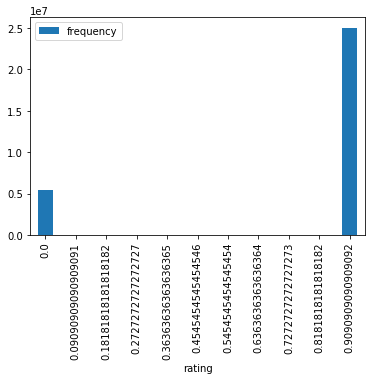

In [37]:
## usamos los el logaritmo de la venta bruta

# Doing the heavy lifting in Spark. We could leverage the `histogram` function from the RDD api

log_histogram = ratings_train_binario_tf_idf.select('rating').rdd.flatMap(lambda x: x).histogram(11)

# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(
    list(zip(*log_histogram)), 
    columns=['rating', 'frequency']
).set_index(
    'rating'
).plot(kind='bar')

De acuerdo al análisis del logaritmo de la venta bruta los valores cuyo  logaritmo sean menos que cero serán considerados con label 0 y los mayores a 0 con label 1 para asi crear el rating implicito